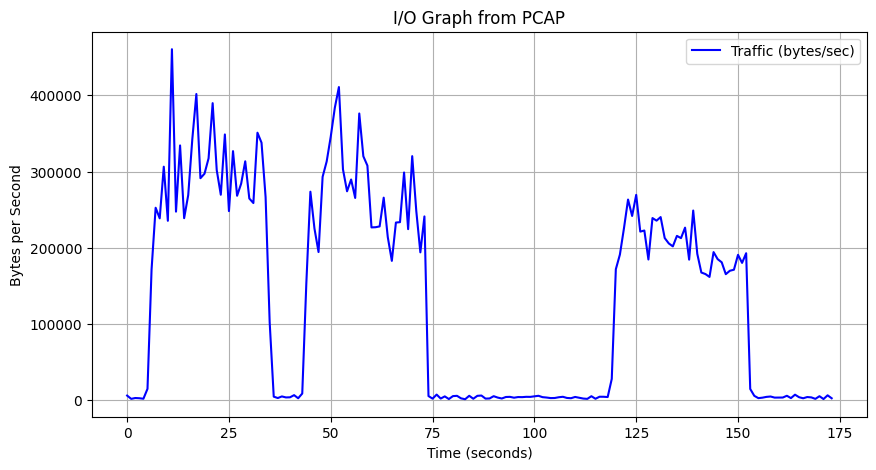

In [2]:
from scapy.all import rdpcap, IP, IPv6, TCP, UDP
import matplotlib.pyplot as plt
import numpy as np

RAW_DATA_DIR = "raw_data"
# Load PCAP file
pcap_file = f"{RAW_DATA_DIR}/curl_3_1g_downloads.pcap"
packets = rdpcap(pcap_file)

# Filter packets (e.g., only TCP traffic)
timestamps = []
packet_sizes = []


for pkt in packets:
    if TCP in pkt:  # Adjust filter as needed
        timestamps.append(pkt.time)  # Capture timestamp
        packet_sizes.append(len(pkt))  # Capture packet size

# Convert timestamps to relative time
start_time = timestamps[0]
timestamps = np.array(timestamps) - start_time

# Bin data into 1-second intervals
time_bins = np.arange(0, timestamps[-1] + 1, 1)  # Adjust bin size if needed
traffic_volume, _ = np.histogram(timestamps, bins=time_bins, weights=packet_sizes)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_bins[:-1], traffic_volume, label="Traffic (bytes/sec)", color="b")
plt.xlabel("Time (seconds)")
plt.ylabel("Bytes per Second")
plt.title("I/O Graph from PCAP")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Dictionary to store streams (key = 5-tuple, value = [timestamps, sizes])
streams = {}

for pkt in packets:
    if (IP in pkt or IPv6 in pkt) and (TCP in pkt or UDP in pkt):
        # Identify stream: (Src IP, Dst IP, Src Port, Dst Port, Protocol)
        if IP in pkt:
            stream_id = (pkt[IP].src, pkt[IP].dst, pkt.sport, pkt.dport)
        elif IPv6 in pkt:
            stream_id = (pkt[IPv6].src, pkt[IPv6].dst, pkt.sport, pkt.dport)

        # Store timestamps & packet sizes per stream
        if stream_id not in streams:
            streams[stream_id] = ([], [])
        streams[stream_id][0].append(pkt.time)  # Timestamp
        streams[stream_id][1].append(len(pkt))  # Packet Size

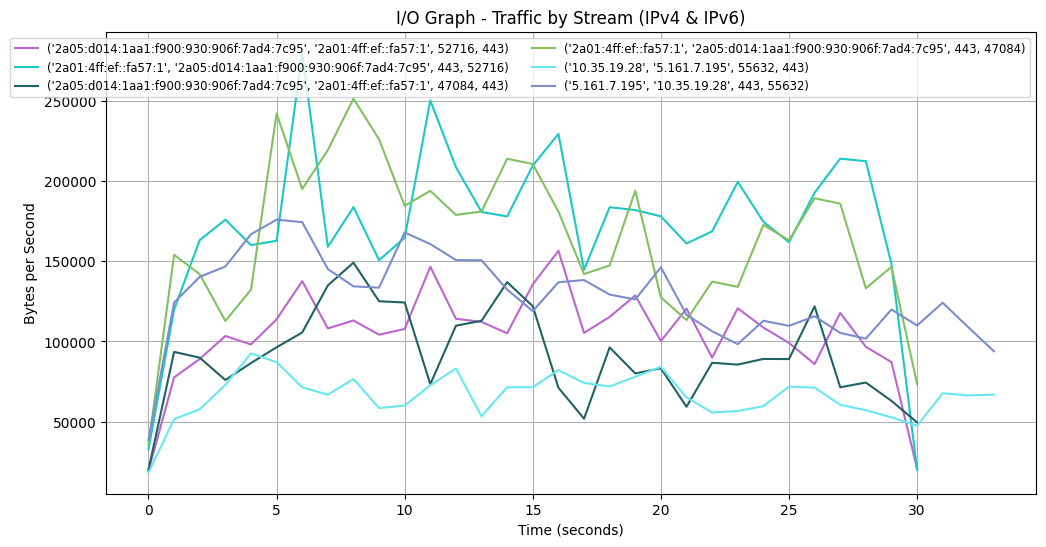

In [4]:
import random

# Generate colors for streams
stream_colors = {stream: (random.random(), random.random(), random.random()) for stream in streams}

# Plot each stream
plt.figure(figsize=(12, 6))

for stream_id, (timestamps, sizes) in streams.items():
    if not timestamps:
        continue
    # Filter large-size transfers only
    if len(timestamps) < 2000:
        continue

    # Normalize timestamps (optional, to align streams)
    start_time = min(timestamps)
    timestamps = np.array(timestamps) - start_time

    # Bin data into 1-second intervals
    time_bins = np.arange(0, timestamps[-1] + 1, 1)
    traffic_volume, _ = np.histogram(timestamps, bins=time_bins, weights=sizes)

    # Assign color & plot stream
    color = stream_colors[stream_id]
    plt.plot(time_bins[:-1], traffic_volume, label=f"{stream_id}", color=color)

plt.xlabel("Time (seconds)")
plt.ylabel("Bytes per Second")
plt.title("I/O Graph - Traffic by Stream (IPv4 & IPv6)")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True)
plt.show()